In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter3_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-29 11:26:06.916123


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae2_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae2_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter2")

dec: h_dim 32
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter2 ckpt_iwvi_pendulum_policy_optimization_iter2
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter2
base load self.initial_belief.data.sum() tensor(-2.8015)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(0.4515)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(45.7422)
train_loss:  -5.0808569580078125
valid_loss:  -5.327962623596191
h_min_tilde -6.1621203 ell_tilde -5.130278091125489 kappa_tilde 0.000984449281768236
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter2
train_loss:  -0.9243779229491951
valid_loss:  -0.5832687792778015
weight_alpha 1.0 h_min_tilde -6.1621203 ell_tilde -0.8561560942149165 kappa_tilde 0.0004341280428292296


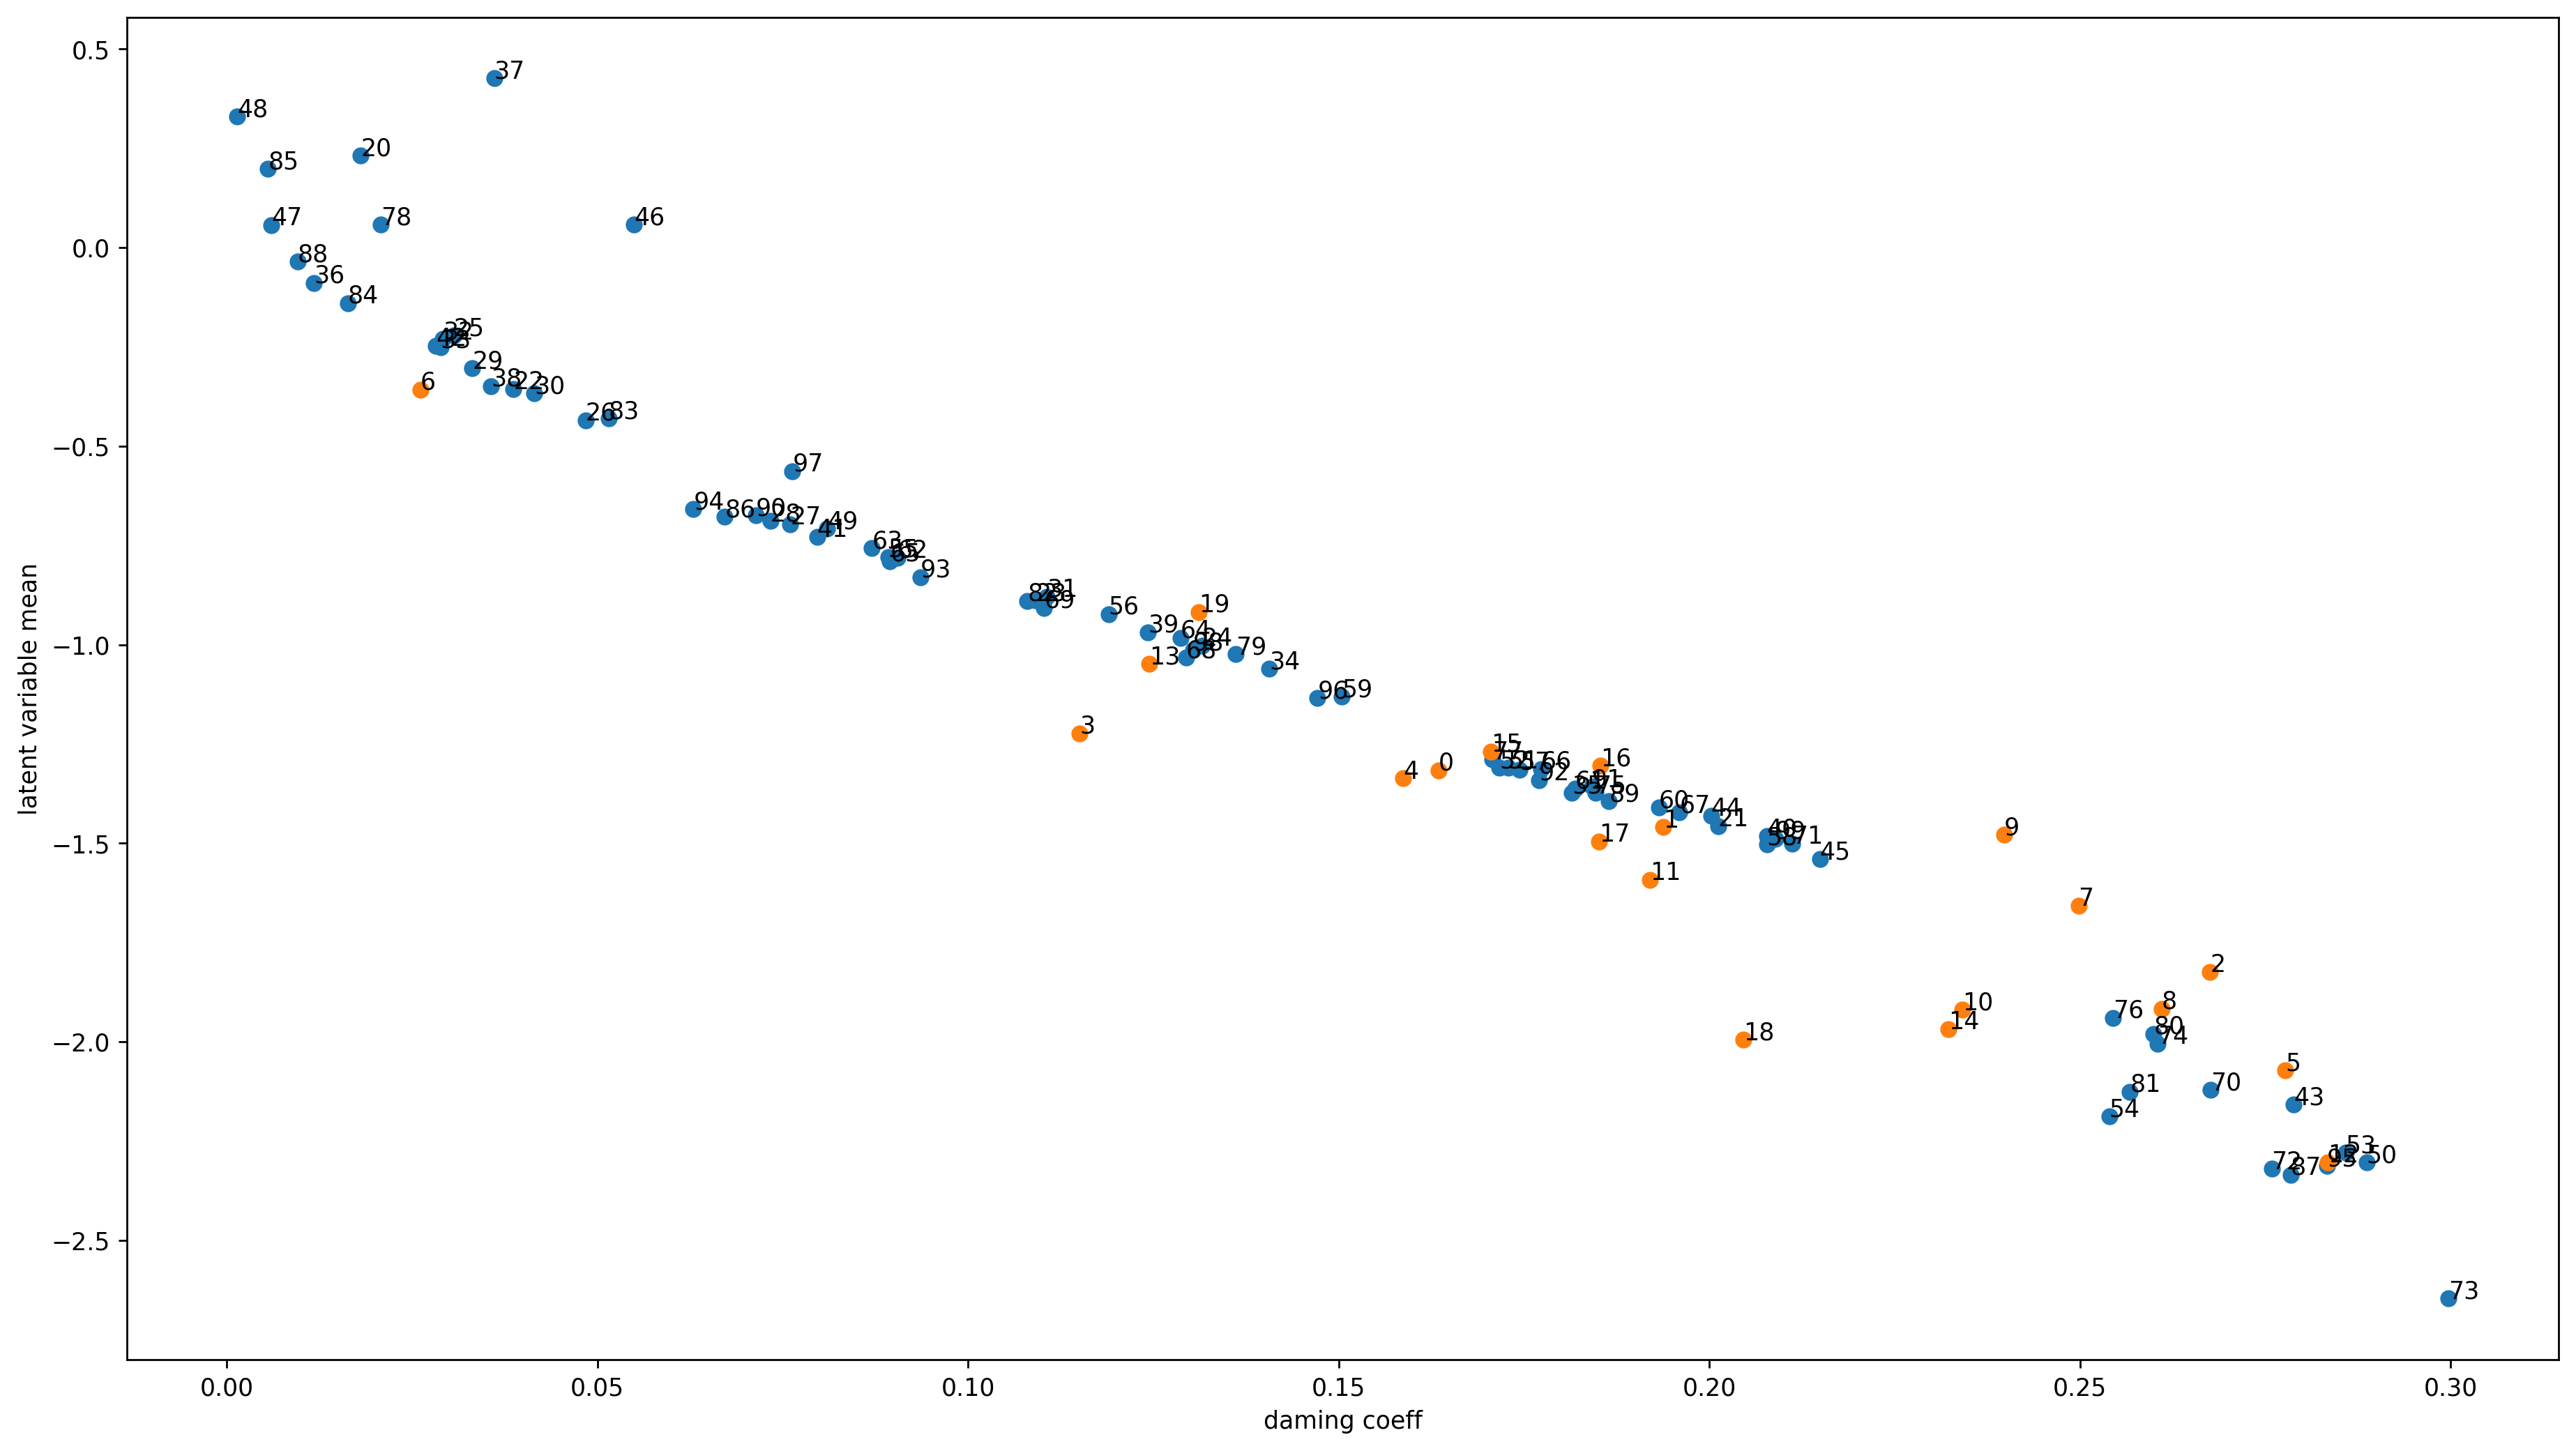

[0.16346495 0.19376823 0.2675319  0.11503246 0.15866848 0.27767899
 0.02613879 0.24978595 0.26100364 0.23974757]
[0.23415875 0.19197631 0.28340068 0.12439858 0.23227011 0.17053018
 0.18529065 0.1850802  0.20454609 0.13110959]
[0.01806764 0.20119136 0.03867789 0.10911323 0.13158045 0.03061344
 0.04839286 0.07598748 0.07332768 0.03311254]
[0.04145489 0.11061755 0.02913038 0.02882952 0.14059536 0.18145366
 0.01175634 0.03605897 0.03561832 0.1242789 ]
[0.20774164 0.07961685 0.02818215 0.27878886 0.20022311 0.21489816
 0.05495741 0.00603226 0.00140864 0.08100239]
[0.28865656 0.1728472  0.17167557 0.2858247  0.2539226  0.08923109
 0.11895172 0.17438186 0.20775948 0.15039731]
[0.19319706 0.18191796 0.09047245 0.08702328 0.12863061 0.0894847
 0.17726183 0.19596025 0.12942553 0.11026856]
[0.26757701 0.21116658 0.27584478 0.2996541  0.26043782 0.18466787
 0.25440247 0.17073022 0.0207501  0.1360628 ]
[0.2599147  0.256741   0.10799342 0.0514889  0.0163014  0.00555654
 0.06717741 0.27842439 0.00955

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 9.5367431640625e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.6464059352874756

 2 3.3215396404266357

 3 3.429414987564087

 4 3.0775837898254395

 5 2.996614456176758

 6 3.5382332801818848

 7 3.2334916591644287

 8 3.4244682788848877

 9 3.4179189205169678

 10 3.2487032413482666

 11 3.2498819828033447

 12 3.1017510890960693

 13 3.2592642307281494

 14 3.09470272064209

 15 3.0869944095611572

 16 3.067511796951294

 17 3.111581325531006

 18 3.0161898136138916

 19 3.064544916152954

 20 3.0592217445373535

 21 3.177211284637451

 22 3.035554885864258

 23 3.0786073207855225

 24 3.0017828941345215

 25 3.0737953186035156

 26 3.000231981277466

 27 3.0486600399017334

 28 2.9705963134765625

 29 2.9761314392089844

 30 3.0891177654266357

 31 3.098170280456543

 32 3.0524630546569824

 33 2.997507333755493

 34 3.0527124404907227

 35 3.0982844829559326

 36 2.9971706867218018

 37 3.116940498352051

 38 3.0493645668029785

 39 3.023655652999878

 40 3.109607219696045

 41 3.0448238849639893

 42 3.2024741172790527

 43 3.025968074

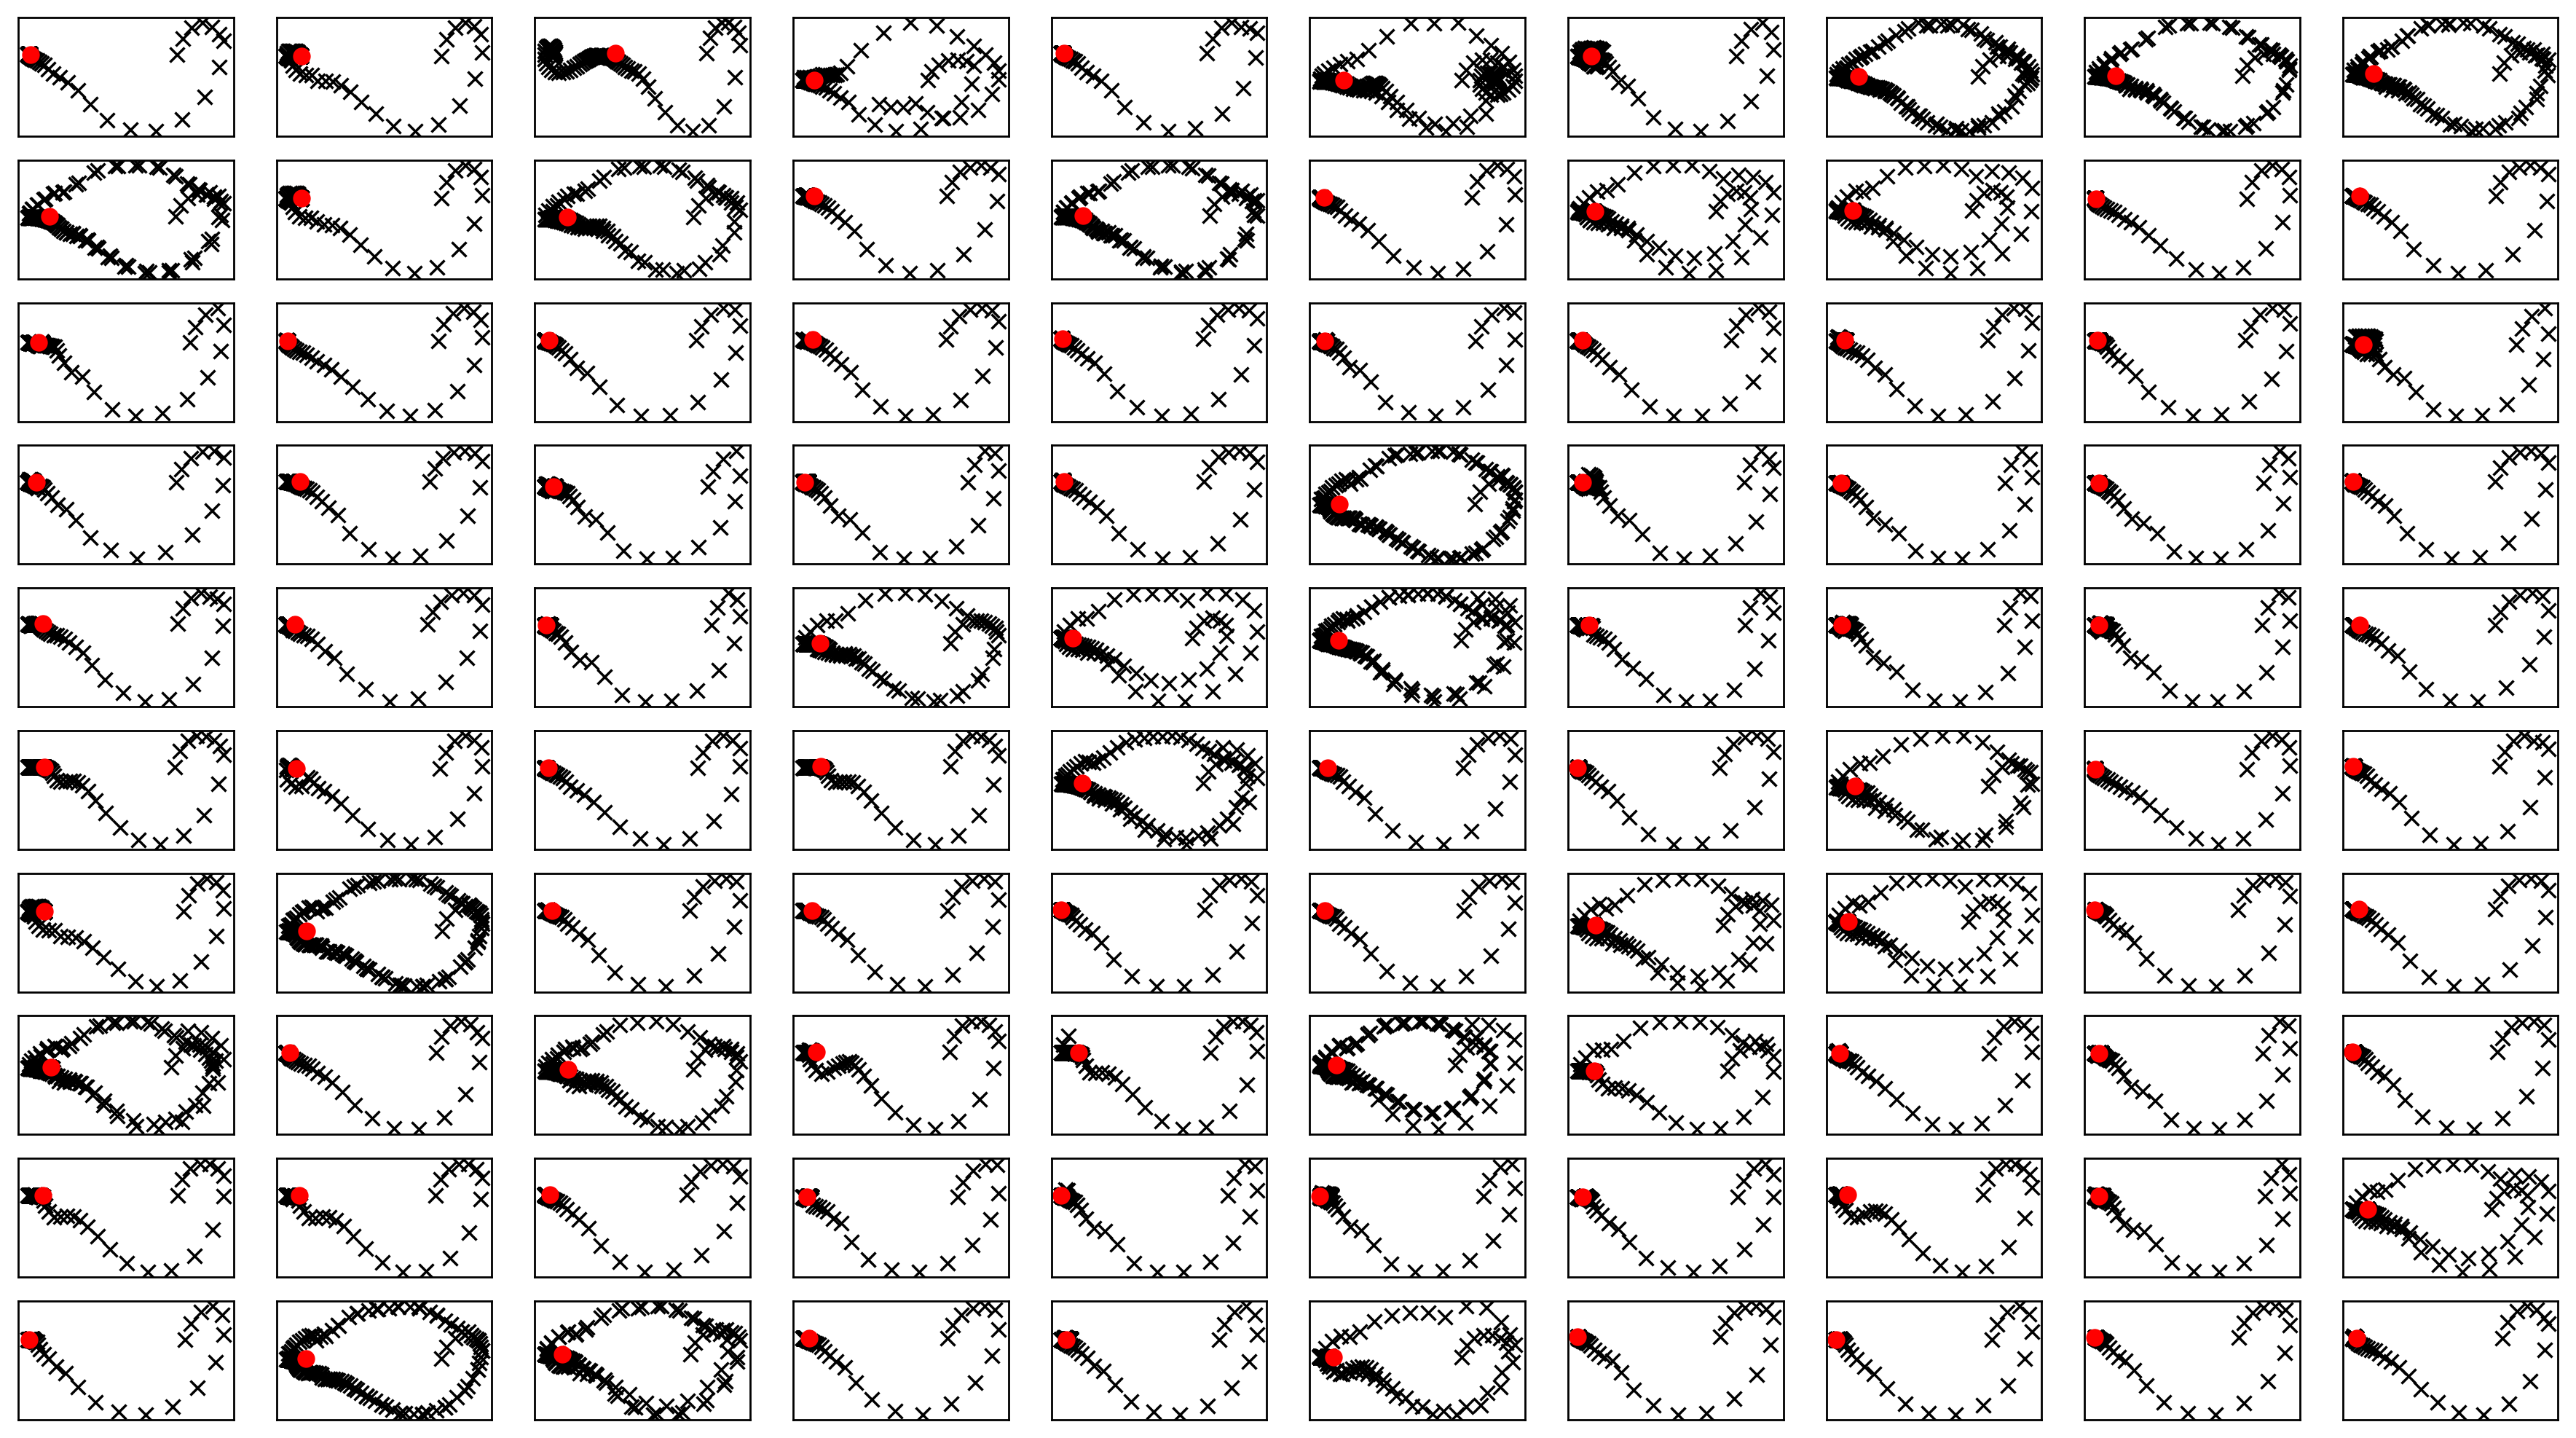

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.1771984100341797

 2 3.1876955032348633

 3 3.152439594268799

 4 3.1833674907684326

 5 3.2174792289733887

 6 3.185216188430786

 7 3.1279048919677734

 8 3.225315809249878

 9 3.1691839694976807

 10 3.122779607772827

 11 3.216357469558716

 12 3.0644474029541016

 13 2.9802496433258057

 14 3.1376185417175293

 15 3.3196828365325928

 16 3.0906710624694824

 17 3.185817003250122

 18 3.086327314376831

 19 3.1680562496185303

 20 3.0438292026519775

 21 3.1634764671325684

 22 3.113351345062256

 23 3.066697835922241

 24 3.015460729598999

 25 3.162693500518799

 26 3.104667901992798

 27 3.0777156352996826

 28 3.2202224731445312

 29 3.1268417835235596

 30 3.175910711288452

 31 3.0939981937408447

 32 3.0296437740325928


In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())